In [1]:
%load_ext autoreload
%autoreload 2

import sys
import os

# Get current working directory (where notebook is running)
current_dir = os.getcwd()
# Go up one level, then into utils
utils_path = os.path.abspath(os.path.join(current_dir, '..', 'utils'))
# Add to sys.path
sys.path.append(utils_path)

from trend_regime_utils import load_trend_data, process_trend_data, create_advanced_feat, mayority_vote_cluster_smooth
from bull_trend_regime_utils import load_bull_trend_data, create_advanced_bull_feat, merge_clean_final_clusters

import pandas as pd
import numpy as np
from datetime import datetime
from zoneinfo import ZoneInfo
import joblib

# For API Keys
from dotenv import load_dotenv
# Alpaca API keys
API_KEY = None
SECRET_KEY = None

load_dotenv(override=True)

if API_KEY is None:
    API_KEY = os.environ.get('ALP_API_KEY')

if SECRET_KEY is None:
    SECRET_KEY = os.environ.get('ALP_SEC_KEY')

In [2]:
EARLIEST_DATE = datetime(2016, 1, 16, tzinfo=ZoneInfo('America/New_York'))
LAST_DATE = datetime(2025, 7, 20, tzinfo=ZoneInfo('America/New_York'))

df_trend_raw = load_trend_data(API_KEY, SECRET_KEY, EARLIEST_DATE, LAST_DATE)

df_trend_processed = process_trend_data(df_trend_raw)

df_trend_feat = create_advanced_feat(df_trend_processed)

c:\Users\sergi\Documents\TFG\utils\trend_regime_utils.py:96: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_feat = df_subset.groupby('symbol').apply(compute_trend_features)
c:\Users\sergi\Documents\TFG\utils\trend_regime_utils.py:96: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_feat = df_subset.groupby('symbol').apply(compute_trend_features)
c:\Users\sergi\Documents\TFG\utils\trend_regime_utils.py:96: FutureWar

In [3]:
# Get the project root (one level up from current working directory)
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), '..'))
MODEL_DIR = os.path.join(PROJECT_ROOT, 'models')

os.makedirs(MODEL_DIR, exist_ok=True)

## If want to predict
# Load models
scaler = joblib.load(os.path.join(MODEL_DIR, "trend_scaler.pkl"))
umap_model = joblib.load(os.path.join(MODEL_DIR, "trend_umap_model.pkl"))
gmm_model = joblib.load(os.path.join(MODEL_DIR, "trend_gmm_model.pkl"))

# scale data
trend_scaled = scaler.transform(df_trend_feat)

# Apply UMAP transformation
trend_umap = umap_model.transform(trend_scaled)

# Predict clusters
trend_gmm_labels = gmm_model.predict(trend_umap)

# from sklearn.metrics import silhouette_score
# print(silhouette_score(trend_umap, trend_gmm_labels))

df_with_clusters = pd.DataFrame(trend_gmm_labels, columns=["cluster"], index=df_trend_feat.index)

df_cluster_smooth = mayority_vote_cluster_smooth(df_with_clusters)

In [4]:
df_bull_raw = load_bull_trend_data(API_KEY, SECRET_KEY, EARLIEST_DATE, LAST_DATE)

bull_features_df = create_advanced_bull_feat(df_bull_raw)

In [5]:
# keep only bull days 
bull_days = df_cluster_smooth[df_cluster_smooth==1]

# Keep only rows in bull_features_df where the index exists in bull_days
only_bull_features_df = bull_features_df[bull_features_df.index.isin(bull_days.index)]

In [6]:
## If want to predict
# Load models
bull_scaler = joblib.load(os.path.join(MODEL_DIR, "bull_trend_scaler.pkl"))
bull_umap_model = joblib.load(os.path.join(MODEL_DIR, "bull_trend_umap_model.pkl"))
spectral_model = joblib.load(os.path.join(MODEL_DIR, "bull_trend_spectral_model.pkl"))

# scale data
bull_trend_scaled = bull_scaler.transform(only_bull_features_df)

# Apply UMAP transformation
bull_trend_umap = bull_umap_model.transform(bull_trend_scaled)

# Predict clusters, SpectralClustering doesn’t have a .predict() method for unseen data.
# Every time you call fit_predict(), it re-computes clusters from scratch, so for new data, you need to re-run it on all data (old + new)
bull_trend_spectral_labels = spectral_model.fit_predict(bull_trend_umap)

# from sklearn.metrics import silhouette_score
# print(silhouette_score(bull_trend_umap, bull_trend_spectral_labels))

c:\Users\sergi\Documents\TFG\.venv\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


In [7]:
# compute final clusters
df_final_clusters = merge_clean_final_clusters(bull_trend_spectral_labels, only_bull_features_df, df_with_clusters)

df_final_clusters.value_counts(normalize=True, dropna=False)

final_cluster
1                0.251719
0                0.240257
2                0.187987
3                0.175608
4                0.144429
Name: proportion, dtype: float64

In [8]:
tickers_to_trade = [
    "SPY",  # S&P 500 ETF
    "EFA",  # MSCI EAFE (Developed Markets ex-US) ETF
    "EEM",  # MSCI Emerging Markets ETF
    "TLT",  # 20+ Year Treasury Bond ETF
    "GLD",  # Gold ETF
    "USO",  # Crude Oil ETF
    "QQQ",  # Nasdaq 100 ETF
    "IWM"   # Russell 2000 ETF
]

df_trade_raw = load_trend_data(API_KEY, SECRET_KEY, EARLIEST_DATE, LAST_DATE, all_tickers=tickers_to_trade)

print("NAs: ", df_trade_raw.pivot(columns="symbol").isna().sum().sum())

NAs:  0


In [9]:
def add_sma_crossover(df, short_window, long_window, signal_name):
    """Buy when short SMA crosses above long SMA, sell when crosses below."""
    """Trend-following / Momentum"""
    df = df.copy()
    df['SMA_short'] = df['close'].rolling(short_window).mean()
    df['SMA_long'] = df['close'].rolling(long_window).mean()
    df[signal_name] = np.where(df['SMA_short'] > df['SMA_long'], 1, -1)
    return df.drop(columns=['SMA_short', 'SMA_long'])

def add_rsi(df, period, signal_name):
    """Buy when RSI < 30 (oversold), sell when RSI > 70 (overbought)."""
    """Mean reversion"""
    df = df.copy()
    delta = df['close'].diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=period, min_periods=period).mean()
    avg_loss = loss.rolling(window=period, min_periods=period).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    df['RSI'] = rsi
    df[signal_name] = np.where(df['RSI'] < 30, 1, np.where(df['RSI'] > 70, -1, 0)) # 65 35 for large periods maybe
    return df.drop(columns=['RSI'])


def add_bollinger_bands(df, window, num_std, signal_name):
    """Buy when price closes below lower band, sell when above upper band."""
    """Volatility breakout & Reversion"""
    df = df.copy()
    sma = df['close'].rolling(window).mean()
    rolling_std = df['close'].rolling(window).std()
    upper_band = sma + num_std * rolling_std
    lower_band = sma - num_std * rolling_std
    df[signal_name] = np.where(df['close'] < lower_band, 1, np.where(df['close'] > upper_band, -1, 0))
    return df

# ---- Apply all strategies ----
def add_all_strategies(df):
    df = add_sma_crossover(df, short_window=5, long_window=10, signal_name="S1_1_signal")
    df = add_sma_crossover(df, short_window=10, long_window=20, signal_name="S1_2_signal")
    df = add_sma_crossover(df, short_window=14, long_window=28, signal_name="S1_3_signal")
    df = add_rsi(df, period=7, signal_name="S2_1_signal")
    df = add_rsi(df, period=14, signal_name="S2_2_signal")
    df = add_rsi(df, period=21, signal_name="S2_3_signal")
    df = add_bollinger_bands(df, window=10, num_std=1, signal_name="S3_1_signal")
    df = add_bollinger_bands(df, window=20, num_std=1, signal_name="S3_2_signal")
    df = add_bollinger_bands(df, window=40, num_std=1.5, signal_name="S3_3_signal")
    return df

df_strats = add_all_strategies(df_trade_raw)

# How This Works
# Signals are numeric:
# 1 = long bias,
# -1 = short bias,
# 0 = neutral (for RSI & Bollinger).

# No lookahead bias in signal generation: All rolling and EMA operations use only past data.

# Drop helper columns so only S1_signal to S6_signal remain, ready for ML feature building.

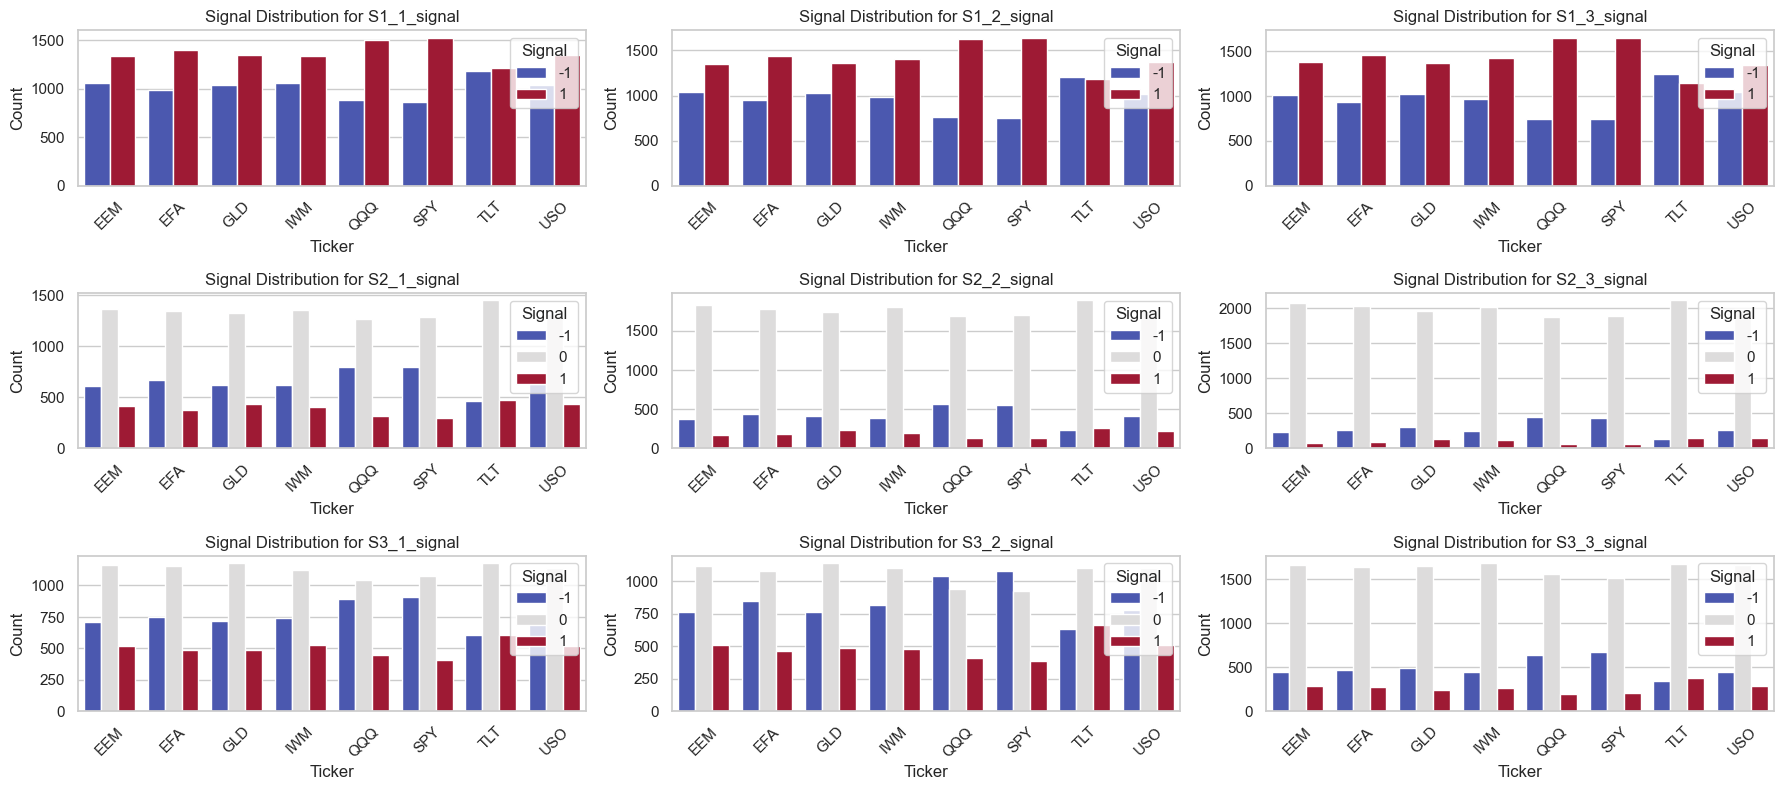

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_signal_distribution(df, signal_cols, symbol_col='symbol'):
    """
    Plots barplots showing distribution of signal values (1, 0, -1)
    per ticker and per strategy in a 3x2 subplot layout.
    """
    sns.set(style="whitegrid")
    
    # Create subplots
    fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(18, 10))
    axes = axes.flatten()  # Flatten to easily iterate
    
    for i, strat in enumerate(signal_cols):
        ax = axes[i]
        
        # Count frequency of each signal per ticker
        counts = (
            df.groupby(symbol_col)[strat]
            .value_counts()
            .unstack(fill_value=0)
            .reset_index()
            .melt(id_vars=symbol_col, var_name='Signal', value_name='Count')
        )
        
        # Plot on the corresponding subplot
        sns.barplot(data=counts, x=symbol_col, y='Count', hue='Signal', palette='coolwarm', ax=ax)
        
        ax.set_title(f"Signal Distribution for {strat}", fontsize=12)
        ax.set_xlabel("Ticker")
        ax.set_ylabel("Count")
        ax.legend(title="Signal")
        ax.tick_params(axis='x', rotation=45)

    # Hide any unused subplots if signal_cols < 6
    for j in range(len(signal_cols), 12):
        fig.delaxes(axes[j])
    
    plt.tight_layout()
    plt.show()

strategies = ["S1_1_signal", "S1_2_signal", "S1_3_signal", "S2_1_signal", "S2_2_signal", "S2_3_signal", "S3_1_signal", "S3_2_signal", "S3_3_signal"]

plot_signal_distribution(df_strats, strategies)

In [11]:
HORIZON = 10

def compute_forward_returns(df, horizon=HORIZON):
    """
    For each symbol and timestamp, compute forward return over `horizon` days.
    Forward return = (close at t+horizon / close at t) - 1
    """
    df = df.copy()
    df['forward_return'] = df.groupby('symbol')['close'].shift(-horizon) / df['close'] - 1
    return df

def generate_strategy_returns(df, horizon=HORIZON):
    """
    For each strategy S1..S6, compute forward return assuming you go LONG when signal=1,
    SHORT when signal=-1, and 0 when neutral (signal=0).
    
    The strat_return per row per strategy is:
      forward_return * signal at current time
    
    Returns a DataFrame in long format:
      ['symbol', 'timestamp', 'strategy', 'signal', 'forward_return', 'strat_return']
    """
    df = df.copy()
    df = compute_forward_returns(df, horizon=horizon)
    
    strategy_cols = ["S1_1_signal", "S1_2_signal", "S1_3_signal", "S2_1_signal", "S2_2_signal", "S2_3_signal", "S3_1_signal", "S3_2_signal", "S3_3_signal"]
    records = []
    
    for strat in strategy_cols:
        temp = df[['symbol', 'close', strat, 'forward_return']].copy()
        temp = temp.rename(columns={strat: 'signal'})
        temp['strategy'] = strat
        
        # strat_return is forward return weighted by position signal
        # Long = profit if price rises, Short = profit if price falls
        temp['strat_return'] = temp['forward_return'] * temp['signal']
        
        ###### Optionally remove neutral signals to reduce noise
        # Neutral signals are safe to exclude if you want your model to focus on
        #  performance conditional on entering a trade. Keep them if you want 
        # the model to learn when to trade vs when not to
        temp = temp[temp['signal'] != 0]
        
        records.append(temp[['symbol', 'strategy', 'signal', 'forward_return', 'strat_return']])
    
    df_strat_returns = pd.concat(records).reset_index()
    return df_strat_returns.set_index('timestamp')


df_return_strats = generate_strategy_returns(df_strats, horizon=HORIZON)

In [12]:
        ###### Optionally remove neutral signals to reduce noise
        # Neutral signals are safe to exclude if you want your model to focus on
        #  performance conditional on entering a trade. Keep them if you want 
        # the model to learn when to trade vs when not to

In [13]:
# shift clusters since they are computed at the end of the day, so that info is not available, drop frist day since is nan
shifted_regimes = df_final_clusters[["final_cluster"]].shift(1).dropna().astype(int)

# join with clusters (first months have no cluster so have to drop them)
df_joined = df_return_strats.join(shifted_regimes, how='inner')
df_joined.rename(columns={"final_cluster": "prev_regime"}, inplace=True)

df_joined.drop(columns="forward_return", inplace=True)
# drop last days without available returns
df_joined.dropna(subset=['strat_return'], inplace=True)

df_joined

,symbol,strategy,signal,strat_return,prev_regime
timestamp,,,,,
2016-11-14 05:00:00+00:00,EEM,S1_1_signal,-1,-0.033131,3
2016-11-15 05:00:00+00:00,EEM,S1_1_signal,-1,-0.015712,3
2016-11-16 05:00:00+00:00,EEM,S1_1_signal,-1,-0.013028,3
2016-11-17 05:00:00+00:00,EEM,S1_1_signal,-1,-0.010904,3
2016-11-18 05:00:00+00:00,EEM,S1_1_signal,-1,-0.022591,3
...,...,...,...,...,...
2025-06-13 04:00:00+00:00,USO,S3_3_signal,-1,0.088631,1
2025-06-16 04:00:00+00:00,USO,S3_3_signal,-1,0.059295,1
2025-06-17 04:00:00+00:00,USO,S3_3_signal,-1,0.081531,1


C:\Users\sergi\AppData\Local\Temp\ipykernel_8024\3722318940.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


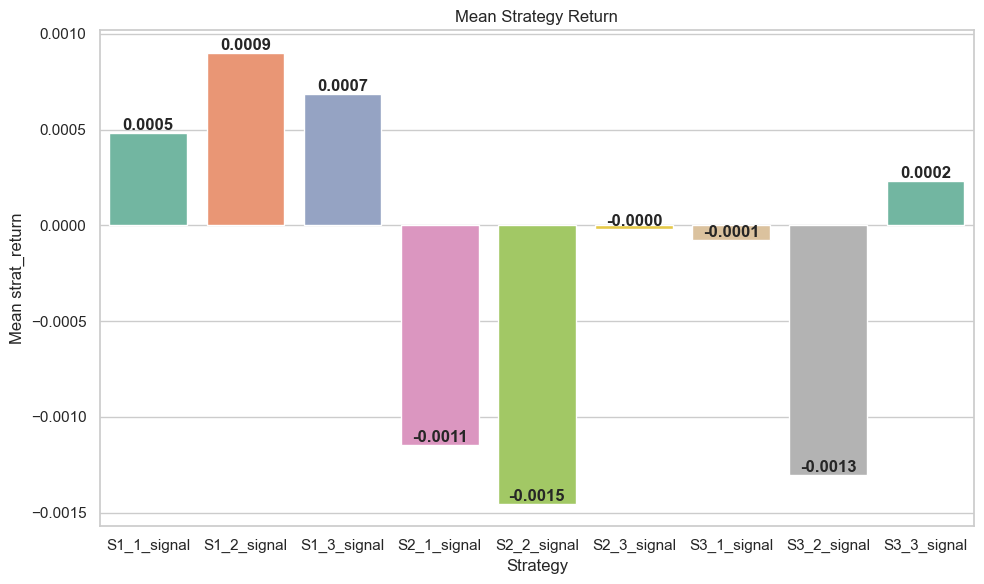

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_mean_return_per_strategy(df):
    """
    Plot mean strat_return grouped only by strategy.
    """
    # Compute mean strat_return per strategy
    grouped = df.groupby('strategy')['strat_return'].mean().reset_index()

    # Set seaborn style
    sns.set(style='whitegrid')

    # Create barplot
    plt.figure(figsize=(10, 6))
    sns.barplot(
        data=grouped,
        x='strategy',
        y='strat_return',
        palette='Set2'
    )

    plt.title('Mean Strategy Return')
    plt.xlabel('Strategy')
    plt.ylabel('Mean strat_return')

    # Add value annotations on top of bars
    for i, row in grouped.iterrows():
        plt.text(i, row['strat_return'], f'{row["strat_return"]:.4f}', ha='center', va='bottom', fontweight='bold')

    plt.tight_layout()
    plt.show()

# Usage:
plot_mean_return_per_strategy(df_joined)

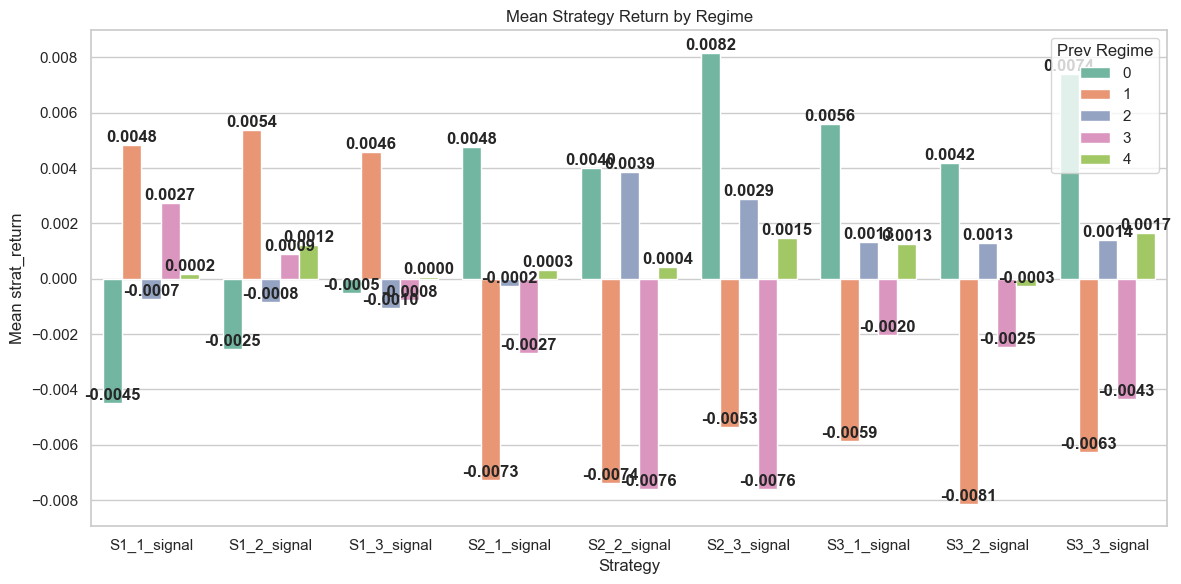

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_mean_return_by_strategy_and_regime(df):
    """
    Plot mean strat_return grouped by strategy and prev_regime.
    """
    # Compute mean strat_return per strategy and regime
    grouped = df.groupby(['strategy', 'prev_regime'])['strat_return'].mean().reset_index()

    # Set seaborn style
    sns.set(style='whitegrid')

    # Create barplot with strategy on x-axis and hue=prev_regime
    plt.figure(figsize=(12, 6))
    sns.barplot(
        data=grouped,
        x='strategy',
        y='strat_return',
        hue='prev_regime',
        palette='Set2'
    )

    plt.title('Mean Strategy Return by Regime')
    plt.xlabel('Strategy')
    plt.ylabel('Mean strat_return')
    plt.legend(title='Prev Regime')

    # Add value annotations on top of bars
    for i, bar in enumerate(plt.gca().patches):
        height = bar.get_height()
        if height:  # Avoid annotating empty bars
            plt.gca().text(
                bar.get_x() + bar.get_width() / 2,
                height,
                f'{height:.4f}',
                ha='center',
                va='bottom',
                fontweight='bold'
            )

    plt.tight_layout()
    plt.show()

# Usage:
plot_mean_return_by_strategy_and_regime(df_joined)


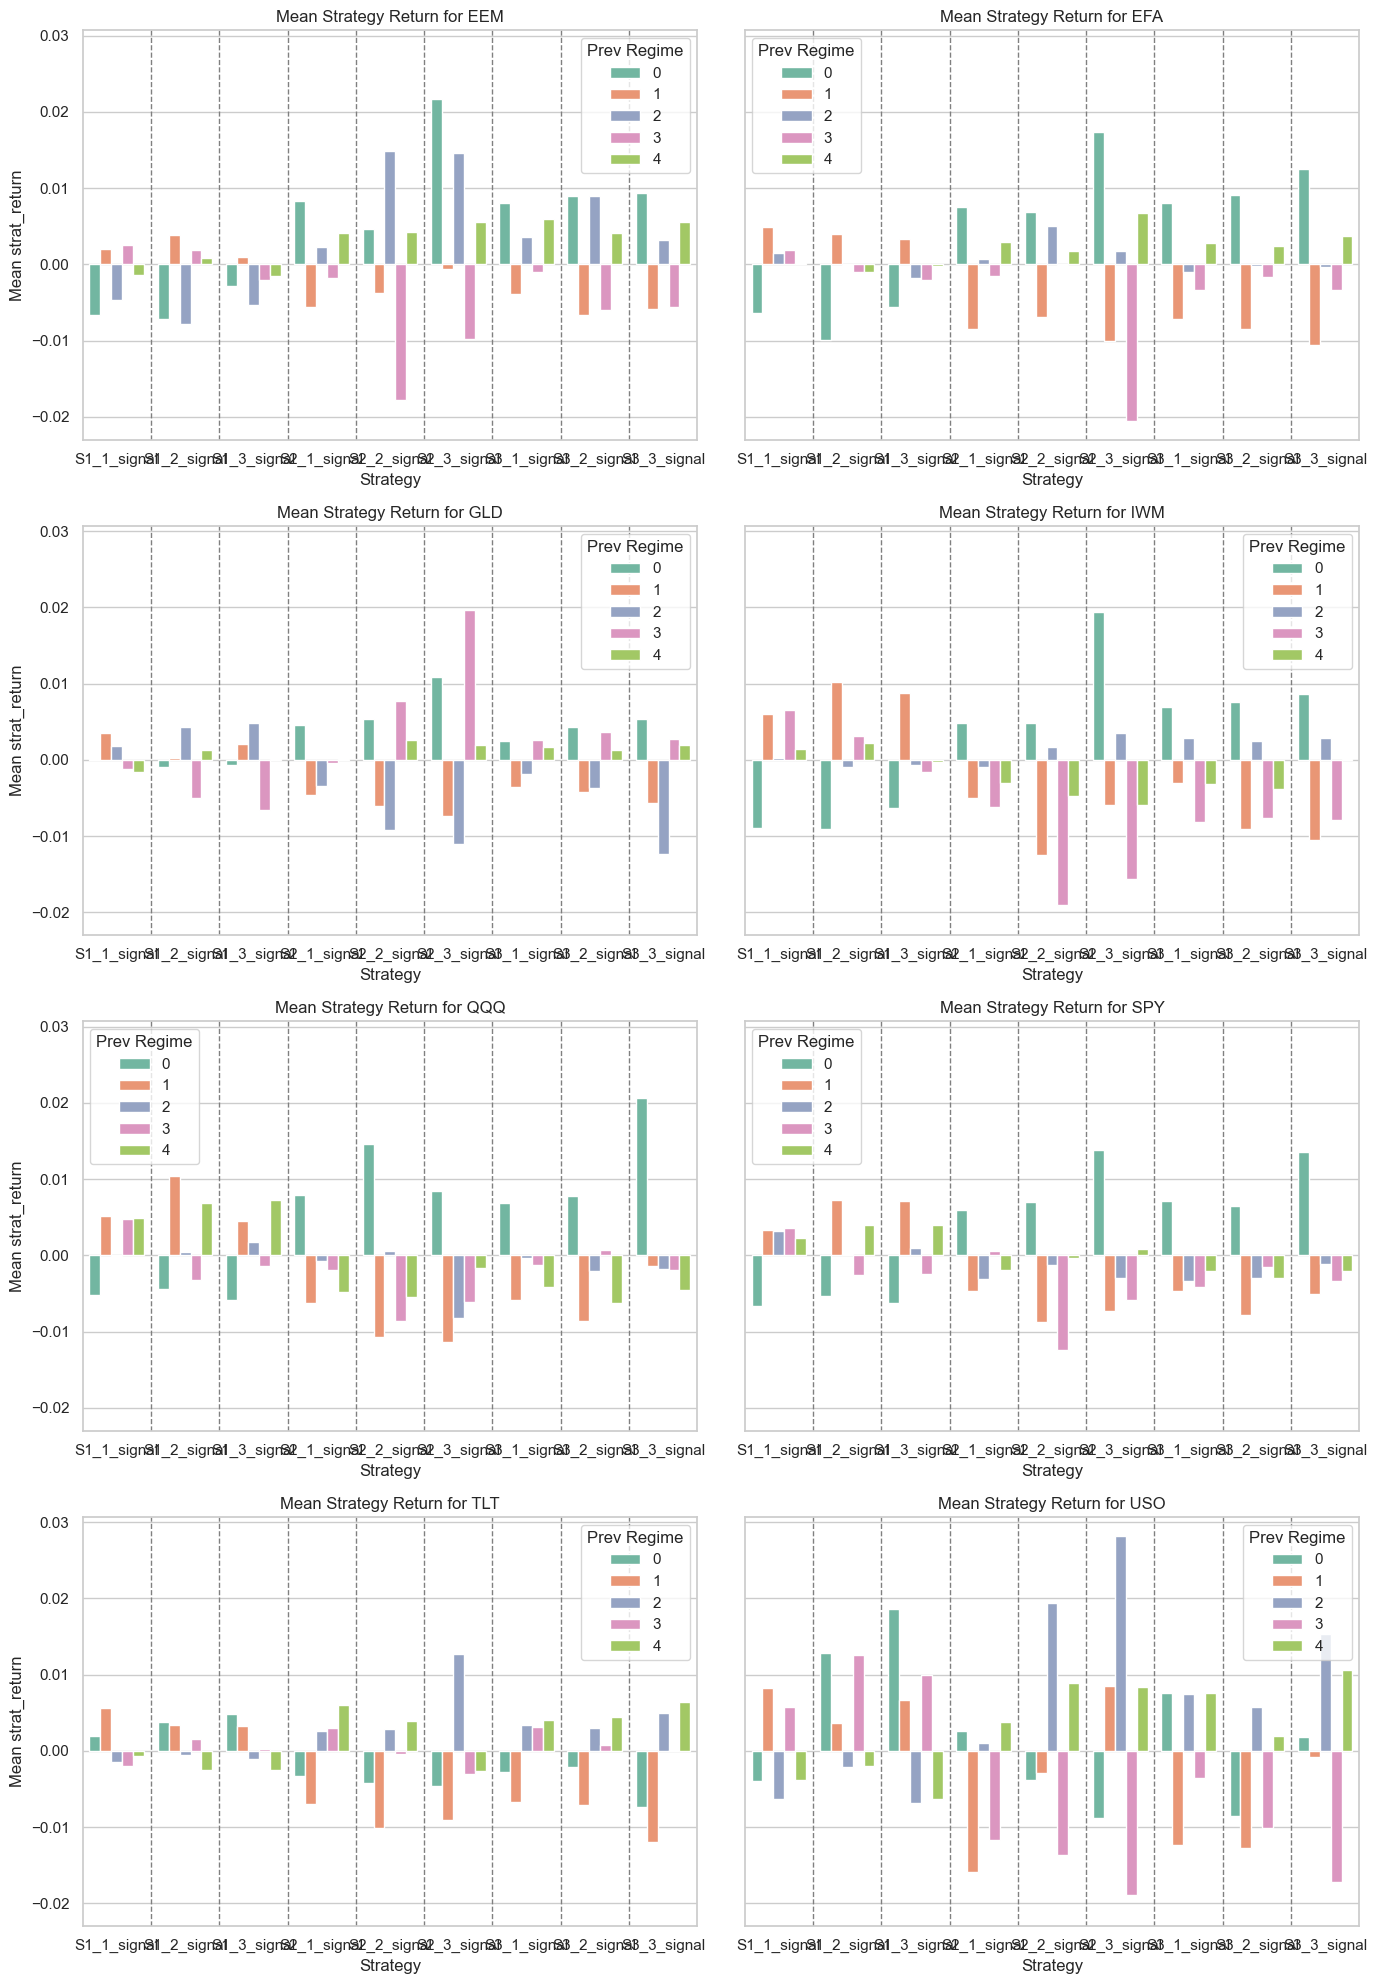

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_mean_strat_return(df):
    """
    Plot mean strat_return grouped by symbol, strategy, and prev_regime.
    """
    # Compute mean strat_return
    grouped = df.groupby(['symbol', 'strategy', 'prev_regime'])['strat_return'].mean().reset_index()

    # Set seaborn style
    sns.set(style='whitegrid')

    symbols = grouped['symbol'].unique()
    n_symbols = len(symbols)

    # Create subplots, one per symbol (adjust cols and rows as needed)
    cols = 2
    rows = (n_symbols + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(14, 5 * rows), sharey=True)
    axes = axes.flatten()

    for i, sym in enumerate(symbols):
        ax = axes[i]
        data = grouped[grouped['symbol'] == sym]

        # Draw barplot with strategy on x-axis, hue=prev_regime
        sns.barplot(
            data=data,
            x='strategy',
            y='strat_return',
            hue='prev_regime',
            ax=ax,
            palette='Set2'
        )

        ax.set_title(f'Mean Strategy Return for {sym}')
        ax.set_xlabel('Strategy')
        ax.set_ylabel('Mean strat_return')
        ax.legend(title='Prev Regime')

        # Add vertical delimiters between strategies
        # Strategies are categorical on x-axis, positions 0,1,2,...,n-1
        n_strategies = data['strategy'].nunique()
        for pos in range(0, n_strategies - 1):
            ax.axvline(pos + 0.5, color='gray', linestyle='--', linewidth=1)

    # Remove empty subplots
    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

# Usage:
plot_mean_strat_return(df_joined)

In [17]:
def add_features(df):
    df = df.copy()

    # 1. Returns
    # df['return_1d'] = df['close'].pct_change(1)
    # df['return_3d'] = df['close'].pct_change(3)
    # df['return_5d'] = df['close'].pct_change(5)

    # # 2. Volatility (rolling std of returns)
    # df['log_return_1d'] = np.log(df['close'] / df['close'].shift(1))
    # df['vol_5d'] = df['log_return_1d'].rolling(window=5).std()
    # df['vol_10d'] = df['log_return_1d'].rolling(window=10).std()
    # df.drop(columns="log_return_1d",  inplace=True)

    # # 3. Momentum (price relative to N-day ago)
    # # df['mom_5d'] = df['close'] / df['close'].shift(5) - 1
    # # df['mom_10d'] = df['close'] / df['close'].shift(10) - 1
    # # df['mom_20d'] = df['close'] / df['close'].shift(20) - 1

    # # 4. Moving averages
    # # df['sma_5d'] = df['close'].rolling(window=5).mean()
    # # df['sma_10d'] = df['close'].rolling(window=10).mean()
    # # df['sma_20d'] = df['close'].rolling(window=20).mean()

    # # 5. Price relative to moving averages
    # df['price_div_sma5'] = df['close'] / df['close'].rolling(window=5).mean() - 1
    # df['price_div_sma10'] = df['close'] / df['close'].rolling(window=10).mean() - 1
    # df['price_div_sma20'] = df['close'] / df['close'].rolling(window=20).mean() - 1

    # # 6. Volume features
    # # df['vol_rolling_5d'] = df['volume'].rolling(window=5).mean()
    # # df['vol_rolling_10d'] = df['volume'].rolling(window=10).mean()
    # # df['vol_rolling_20d'] = df['volume'].rolling(window=20).mean()

    # # 7. Volatility normalized by volume (volume volatility ratio)
    # #df['vol_vol_ratio_5d'] = df['vol_5d'] / (df['vol_rolling_5d'] + 1e-9)

    # # 8. Price range (High-Low) relative to close
    # df['range_pct'] = (df['high'] - df['low']) / df['close']

    # # 9. ATR (Average True Range)
    # high_low = df['high'] - df['low']
    # high_close = np.abs(df['high'] - df['close'].shift())
    # low_close = np.abs(df['low'] - df['close'].shift())
    # tr = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
    # df['atr_7'] = tr.rolling(window=7).mean()
    # df['atr_14'] = tr.rolling(window=14).mean()

    # # 10. Log volume change
    # #df['log_vol_change_1d'] = np.log(df['volume'] + 1) - np.log(df['volume'].shift(1) + 1)

    # Drop rows with NaNs due to rolling calculations
    df = df.dropna()

    return df.drop(columns=["open", "high", "low", "close", "volume", "trade_count", "vwap"])

# Example usage:
df_features = df_trade_raw.groupby('symbol', group_keys=False).apply(add_features)

C:\Users\sergi\AppData\Local\Temp\ipykernel_8024\1789363223.py:58: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_features = df_trade_raw.groupby('symbol', group_keys=False).apply(add_features)


In [18]:
# join with previous dataset
# Set 'symbol' as part of the index
# Join on both index levels (timestamp and symbol)
final_df = df_features.set_index('symbol', append=True).join(df_joined.set_index('symbol', append=True), how='inner')

# back to column
final_df = final_df.reset_index(level='symbol')

# discretize the target, 1 if returns > 0.005 (+0.5%)
final_df["strat_return"] = np.where(final_df["strat_return"] > 0.01, 1, 0)

final_df

,symbol,strategy,signal,strat_return,prev_regime
timestamp,,,,,
2016-11-14 05:00:00+00:00,EEM,S1_1_signal,-1,0,3
2016-11-14 05:00:00+00:00,EEM,S1_2_signal,-1,0,3
2016-11-14 05:00:00+00:00,EEM,S1_3_signal,-1,0,3
2016-11-14 05:00:00+00:00,EEM,S2_2_signal,1,1,3
2016-11-14 05:00:00+00:00,EEM,S3_1_signal,1,1,3
...,...,...,...,...,...
2025-07-02 04:00:00+00:00,USO,S1_3_signal,1,0,4
2025-07-03 04:00:00+00:00,USO,S1_1_signal,-1,0,4
2025-07-03 04:00:00+00:00,USO,S1_2_signal,-1,0,4


In [19]:
final_df["strat_return"].value_counts(normalize=True)

strat_return
0    0.627953
1    0.372047
Name: proportion, dtype: float64

In [20]:
final_df.columns

Index(['symbol', 'strategy', 'signal', 'strat_return', 'prev_regime'], dtype='object')

In [21]:
def walk_forward_splits(df, n_splits=5, min_train_size=0.5):
    """
    Time-aware walk-forward splits.
    - df: DataFrame with timestamp as index, symbol as a column.
    - n_splits: number of folds.
    - min_train_size: fraction of timestamps in the first training set.
    """
    df_reset = df.reset_index()  # bring timestamp into a column
    df_sorted = df_reset.sort_values('timestamp')
    
    timestamps = df_sorted['timestamp'].unique()
    n_timestamps = len(timestamps)
    
    initial_train_end = int(n_timestamps * min_train_size)
    step_size = (n_timestamps - initial_train_end) // n_splits
    
    for i in range(n_splits):
        train_end = initial_train_end + i * step_size
        val_end = train_end + step_size
        
        train_mask = df_sorted['timestamp'] <= timestamps[train_end - 1]
        val_mask = (df_sorted['timestamp'] > timestamps[train_end - 1]) & \
                   (df_sorted['timestamp'] <= timestamps[min(val_end - 1, n_timestamps - 1)])
        
        train_idx = df_sorted[train_mask].index
        val_idx = df_sorted[val_mask].index
        
        yield train_idx, val_idx

In [22]:
import lightgbm as lgb
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, average_precision_score, precision_recall_curve
from itertools import product
import random
import matplotlib.pyplot as plt

def random_search_lightgbm(df, features, target, categorical_features, n_splits=5, n_iter=500):
    param_space = {
        'learning_rate': [0.01, 0.05, 0.1, 0.15],
        'num_leaves': [15, 31, 63],
        'max_depth': [-1, 5, 10, 20],
        'min_data_in_leaf': [10, 20, 50],
        'feature_fraction': [0.6, 0.8, 1.0],
        'bagging_fraction': [0.6, 0.8, 1.0],
        'bagging_freq': [0, 1, 5],
        'lambda_l1': [0.0, 0.1, 1.0],
        'lambda_l2': [0.0, 0.1, 1.0],
        'scale_pos_weight': [1.0, 5.0, 8.0]
    }

    keys, values = zip(*param_space.items())
    all_combinations = [dict(zip(keys, v)) for v in product(*values)]
    sampled_params = random.sample(all_combinations, min(n_iter, len(all_combinations)))

    best_pr_auc = -np.inf
    best_config = None
    best_oof_preds = None
    all_results = []

    for i, params in enumerate(sampled_params):
        print(f"\nTrial {i+1}/{len(sampled_params)}: {params}")
        params.update({
            'objective': 'binary',
            'metric': 'average_precision',
            'boosting_type': 'gbdt',
            'seed': 42
        })

        fold_pr_aucs = []
        fold_accs = []
        oof_preds = np.zeros(len(df))

        for fold, (train_idx, val_idx) in enumerate(walk_forward_splits(df, n_splits=n_splits)):
            train_data = df.iloc[train_idx]
            val_data = df.iloc[val_idx]

            lgb_train = lgb.Dataset(train_data[features], label=train_data[target], categorical_feature=categorical_features)
            lgb_val = lgb.Dataset(val_data[features], label=val_data[target], categorical_feature=categorical_features)

            model = lgb.train(
                params,
                lgb_train,
                valid_sets=[lgb_train, lgb_val],
                num_boost_round=500,
                callbacks=[lgb.early_stopping(stopping_rounds=25)],
            )

            preds_proba = model.predict(val_data[features])
            preds_binary = (preds_proba > 0.5).astype(int)

            oof_preds[val_idx] = preds_proba
            pr_auc_score_val = average_precision_score(val_data[target], preds_proba)
            acc_score = accuracy_score(val_data[target], preds_binary)

            fold_pr_aucs.append(pr_auc_score_val)
            fold_accs.append(acc_score)

        avg_pr_auc = np.mean(fold_pr_aucs)
        avg_acc = np.mean(fold_accs)
        all_results.append({'trial': i+1, 'params': params.copy(), 'avg_pr_auc': avg_pr_auc, 'avg_acc': avg_acc})
        print(f"Avg PR-AUC: {avg_pr_auc:.4f} | Avg Accuracy: {avg_acc:.4f}")

        if avg_pr_auc > best_pr_auc:
            best_pr_auc = avg_pr_auc
            best_config = params.copy()
            best_acc = avg_acc
            best_oof_preds = oof_preds.copy()

    # Retrain best model on full dataset
    lgb_train_full = lgb.Dataset(df[features], label=df[target], categorical_feature=categorical_features)
    best_model = lgb.train(
        best_config,
        lgb_train_full,
        num_boost_round=500
    )

    print(f"\nBest Config: PR-AUC: {best_pr_auc:.4f} | Accuracy: {best_acc:.4f} | params_config {best_config} ")
    return pd.DataFrame(all_results), best_config, best_model, best_oof_preds

def plot_pr_curve_from_oof(oof_preds, y_true):
    precision, recall, _ = precision_recall_curve(y_true, oof_preds)
    pr_auc = average_precision_score(y_true, oof_preds)

    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, color='blue', lw=2, label=f'PR-AUC = {pr_auc:.4f}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Cross-Validation Precision-Recall Curve')
    plt.legend(loc='lower left')
    plt.grid(True)
    plt.show()

In [23]:
# We'll count forward, resetting when the regime changes
consecutive_days = []
count = 0
prev = None
for val in final_df['prev_regime']:
    if val == prev:
        count += 1
    else:
        count = 1  # start counting again
    consecutive_days.append(count)
    prev = val

final_df['consec_days_current_regime'] = consecutive_days

# Last previous regime different from current
last_diff_regime = []
for i, curr_regime in enumerate(final_df['prev_regime']):
    found = np.nan # if no prev regime
    for j in range(i-1, -1, -1):
        if final_df['prev_regime'].iloc[j] != curr_regime:
            found = final_df['prev_regime'].iloc[j]
            break
    last_diff_regime.append(found)

final_df['last_prev_regime_different'] = last_diff_regime

# Days since last occurrence for each regime
for regime_type in range(5):
    col_name = f"days_since_regime_{regime_type}"
    mask = final_df['prev_regime'] == regime_type
    
    last_seen_idx = None
    days_since = []
    
    for i, val in enumerate(final_df['prev_regime']):
        if val == regime_type:
            last_seen_idx = i
            days_since.append(0)
        else:
            if last_seen_idx is None:
                days_since.append(np.nan)  # NaN for never seen
            else:
                days_since.append(i - last_seen_idx)
    
    final_df[col_name] = days_since

In [24]:
final_df.dropna(inplace=True) # drop nan rows that generated with these columns

In [25]:
# ternatively, label encode if your model can handle categories natively (e.g., LightGBM, CatBoost).
#  XGBoost can handle label-encoded categorical features, but only if you use its newer categorical feature support (introduced around v1.5+).
# final_df['strategy'] = final_df['strategy'].astype('category')
# final_df['regime'] = final_df['regime'].astype('category')

# only for Lightgbm or catboost (maybe xgboost also)
# Categorical columns
categ_feats = ['symbol', 'strategy', 'prev_regime', 'last_prev_regime_different']

for feat in categ_feats:
    final_df[feat] = final_df[feat].astype('category')

In [26]:
final_df.columns

Index(['symbol', 'strategy', 'signal', 'strat_return', 'prev_regime',
       'consec_days_current_regime', 'last_prev_regime_different',
       'days_since_regime_0', 'days_since_regime_1', 'days_since_regime_2',
       'days_since_regime_3', 'days_since_regime_4'],
      dtype='object')

In [27]:
# Train LightGBM with walk-forward CV
results_df, best_config, best_model, best_oof_preds = random_search_lightgbm(final_df,
                                                                            final_df.drop(columns=["strat_return"]).columns,
                                                                            categorical_features = categ_feats,
                                                                            target='strat_return',
                                                                            n_splits=5,
                                                                            n_iter=300)


Trial 1/300: {'learning_rate': 0.05, 'num_leaves': 15, 'max_depth': 10, 'min_data_in_leaf': 50, 'feature_fraction': 1.0, 'bagging_fraction': 1.0, 'bagging_freq': 1, 'lambda_l1': 0.0, 'lambda_l2': 1.0, 'scale_pos_weight': 1.0}
[LightGBM] [Info] Number of positive: 16653, number of negative: 29669
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000524 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1497
[LightGBM] [Info] Number of data points in the train set: 46322, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.359505 -> initscore=-0.577512
[LightGBM] [Info] Start training from score -0.577512
Training until validation scores don't improve for 25 rounds
Early stopping, best iteration is:
[35]	training's average_precision: 0.645826	valid_1's average_precision: 0.45118
[LightGBM] [Info] Number of positive: 

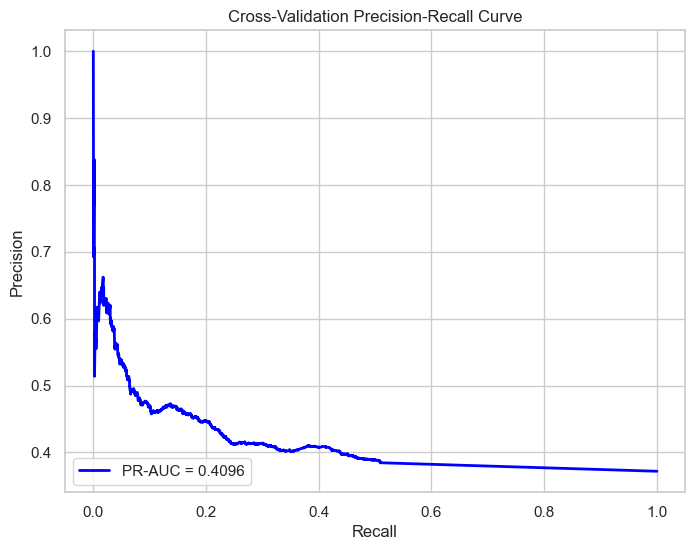

In [28]:
# printed in train is the: Mean of fold scores = average of each fold’s PR-AUC (each fold weighted equally, regardless of size).

# now is the: Global PR-AUC = one curve computed from all OOF predictions at once (folds weighted by number of samples).

plot_pr_curve_from_oof(best_oof_preds, final_df['strat_return'])

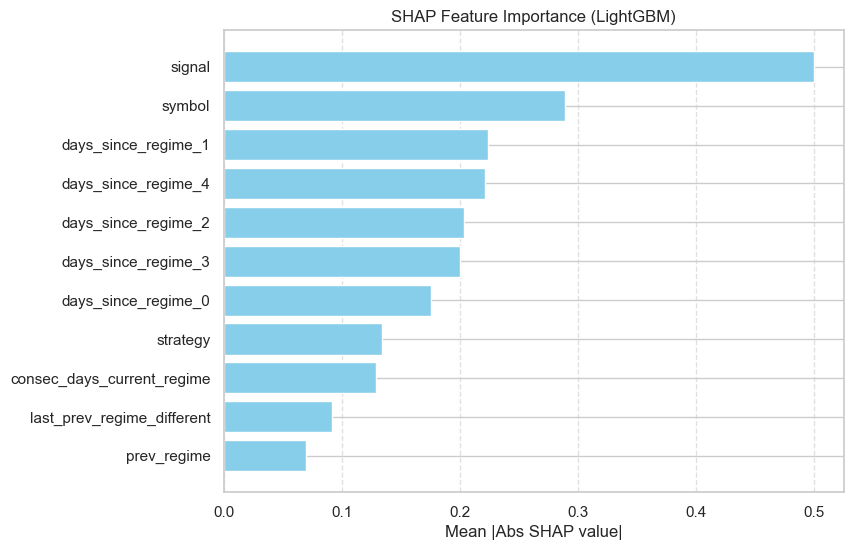

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lightgbm as lgb

def plot_shap_summary(best_model, X):
    # Get SHAP values (pred_contrib=True gives SHAP + bias term as last column)
    shap_values = best_model.predict(X, pred_contrib=True)
    
    # Remove bias term (last column)
    shap_values = shap_values[:, :-1]
    
    feature_names = X.columns
    
    # Mean absolute SHAP value per feature
    shap_importance = np.mean(np.abs(shap_values), axis=0)
    importance_df = pd.DataFrame({
        "feature": feature_names,
        "mean_abs_shap": shap_importance
    }).sort_values(by="mean_abs_shap", ascending=False)

    # Plot bar chart
    plt.figure(figsize=(8, 6))
    plt.barh(importance_df["feature"], importance_df["mean_abs_shap"], color="skyblue")
    plt.xlabel("Mean |Abs SHAP value|")
    plt.title("SHAP Feature Importance (LightGBM)")
    plt.gca().invert_yaxis()
    plt.grid(True, axis='x', linestyle='--', alpha=0.6)
    plt.show()
    
    return importance_df

shap_df = plot_shap_summary(best_model, final_df.drop(columns="strat_return"))

In [30]:
# Use one-hot encoding or target encoding for categorical features (strategy, regime) 
# depending on your model or Embeddings (for deep learning).


# Scale numeric features if needed (standard scaler or robust scaler). only for non-trees

# Experiment with adding more features like volume weighted average price (VWAP), ATR, or more complex technical indicators.